### 1) Setup

In [1]:
import os
import cv2
import math
import copy
from tqdm import tqdm
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import itertools
from torchvision.io import read_image

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset, SubsetRandomSampler
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.models as models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,recall_score, precision_score, f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import OneCycleLR

from PIL import Image, ImageFile
#%matlpotlib inline

In [2]:
torch.cuda.is_available()

True

---

### 2) Data

In [3]:
dir = r"C:\Users\SAMU\Desktop\GP\DermaTech\DermaTech Dataset 2.0"
train_dir = os.path.join(dir, 'train')
test_dir = os.path.join(dir, 'test')

""" python
def getMeanStd (loader):
    mean = 0.
    std = 0.
    count = 0
    for images,_ in loader:
        images_in_batch = images.size(0)
        images = images.view(images_in_batch,images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        count += images_in_batch
    mean /= count
    std /= count
    return mean, std, count"""

In [4]:
img_dim = (224,224)

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                 
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(),                       
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x / 255.0)
])
test_transforms = transforms.Compose([
    transforms.Resize(img_dim),    
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x / 255.0)
])

In [6]:
def checkImage(path):
    im = Image.open(path)
    return True

train_dataset = torchvision.datasets.ImageFolder(root=train_dir,
                                              transform=train_transforms,
                                              is_valid_file=checkImage)

test_dataset = torchvision.datasets.ImageFolder(root=test_dir,
                                             transform=test_transforms,
                                             is_valid_file=checkImage)

In [7]:
labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights, len(train_dataset), replacement=True)

In [8]:
total_samples = len(train_dataset)
classes = len(train_dataset.classes)
class_counts = [0] * classes
class_names = train_dataset.classes

In [9]:
class_names

['Acne and Rosacea',
 'Bug Bites',
 'Eczema',
 'Hair Loss and Diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and Disease']

In [10]:
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 3) Model

In [11]:
def set_device():
    if torch.cuda.is_available():
       dev = "cuda"
    else:
        dev = "cpu"
    return torch.device(dev)

In [12]:
densenet_201 = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
for param in densenet_201.parameters():
    param.requires_grad = False
num_features = densenet_201.classifier.in_features
densenet_201.classifier = nn.Linear(num_features, classes)
device = set_device()
densenet_201 = densenet_201.to(device)

In [13]:
resnet_152 = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
for param in resnet_152.parameters():
    param.requires_grad = False
resnet_ftr = resnet_152.fc.in_features
resnet_152.fc = nn.Linear(resnet_ftr,classes)
device = set_device()
resnet_152 = resnet_152.to(device)

In [14]:
vgg_19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
for param in vgg_19.features.parameters():
    param.requires_grad = False
for param in vgg_19.classifier.parameters():
    param.requires_grad = True
vgg_19.classifier[6] = nn.Linear(vgg_19.classifier[6].in_features, classes)
vgg_ftr = vgg_19.classifier[6].in_features
vgg_19.fc = nn.Linear(vgg_ftr,classes)
device = set_device()
vgg_19 = vgg_19.to(device)

In [15]:
learning_rate = 0.0001
momentum = 0.9
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

w_criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

densenet_optimizer = torch.optim.AdamW(densenet_201.parameters(), lr=0.001, weight_decay=0.0001)
densenet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(densenet_optimizer, factor=0.5, patience=2)

resnet_optimizer = torch.optim.AdamW(resnet_152.parameters(), lr=0.001, weight_decay=0.0001)
resnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer, factor=0.5, patience=2)

vgg_optimizer = torch.optim.AdamW(vgg_19.parameters(), lr=0.001, weight_decay=0.0001)
vgg_scheduler = optim.lr_scheduler.ReduceLROnPlateau(vgg_optimizer, factor=0.5, patience=2)

optim1 = optim.SGD(densenet_201.parameters(), lr=learning_rate, momentum=momentum)
optim2 = optim.SGD(resnet_152.parameters(), lr=learning_rate, momentum=momentum)
optim3 = optim.SGD(vgg_19.parameters(), lr=learning_rate, momentum=momentum)

dn_scheduler = OneCycleLR(optim1, max_lr=0.01, steps_per_epoch=len(train_data_loader), epochs=10)
dn_scheduler = OneCycleLR(optim2, max_lr=0.01, steps_per_epoch=len(train_data_loader), epochs=10)
vn_scheduler = OneCycleLR(optim3, max_lr=0.01, steps_per_epoch=len(train_data_loader), epochs=10)

### 4) Training

In [16]:
def cross_validate(model, dataset, criterion, optimizer, scheduler, model_name, epochs, k_folds=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training {k_folds} folds for {epochs} epochs each")

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_accuracies = []

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(dataset.targets, dataset.targets)):
        print(f"Fold {fold_idx + 1}/{k_folds}")

        train_subsampler = SubsetRandomSampler(train_idx)
        test_subsampler = SubsetRandomSampler(test_idx)

        train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=32, sampler=test_subsampler)

        model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, model_name, epochs)

        accuracy = evaluate_model(model, test_loader)
        fold_accuracies.append(accuracy)

    avg_accuracy = sum(fold_accuracies) / k_folds
    print(f"Average accuracy across {k_folds} folds: {avg_accuracy:.3f}")

    return avg_accuracy

In [17]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, model_name, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_acc = 0.0

    for epoch in range(epochs):
        print("Epoch number %d" % (epoch + 1))
        model.train()
        n_loss = 0.0
        n_correct = 0.0
        total = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, data in progress_bar:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            n_loss += loss.item()
            n_correct += (labels == predicted).sum().item()

            epoch_loss = n_loss / (i + 1)
            epoch_acc = 100.0 * n_correct / total
            progress_bar.set_description(f"Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.3f}%")

        print("Training Dataset got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (n_correct, total, epoch_acc, epoch_loss))

        test_acc = evaluate_model(model, test_loader)
        scheduler.step(test_acc)
        if test_acc > best_acc:
            best_acc = test_acc
            save_checkpoint(model, epoch, optimizer, best_acc, model_name)
            print(f"=> new accuracy of {best_acc} saved")

        print("Done")

    return model

In [15]:
def evaluate_model(model, test_loader):
    model.eval()
    predicted_correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))

    with torch.no_grad():
        for _, data in progress_bar:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_correct += (labels == predicted).sum().item()

            epoch_acc = 100.0 * predicted_correct / total
            progress_bar.set_description(f"Acc: {epoch_acc:.3f}%")

    print(f"Testing Dataset got {predicted_correct} out of {total} images correctly ({epoch_acc:.3f}%).")
    return epoch_acc

In [16]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(14, 12))  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)  
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [17]:
def plot_learning_curves(model):
    train_losses = model.train_losses
    train_accuracies = model.train_accuracies
    val_losses = model.val_losses
    val_accuracies = model.val_accuracies
    
    epochs = len(train_losses)
    
    plt.figure(figsize=(12, 5))
    
    # Plotting losses
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation')
    plt.title(f'{type(model).__name__} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation')
    plt.title(f'{type(model).__name__} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [18]:
def compute_metrics(model, test_loader, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_targets, all_predictions)

    plot_confusion_matrix(cm, classes)

    report = classification_report(all_targets, all_predictions, target_names=classes, output_dict=False)
    print("Classification Report:")
    print(report)

    return report, cm

In [19]:
def compute_metrics2(model, test_loader, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_targets, all_predictions)

    plot_confusion_matrix(cm, classes)

    report = classification_report(all_targets, all_predictions, target_names=classes, output_dict=True)
    print("Classification Report:")
    print(report)

    return report, cm

In [20]:
def compare_and_plot(models, test_loader, classes):
    results = []
    model_names = []

    for model in models:
        model_name = type(model).__name__  
        model_names.append(model_name)
        
        metrics, _ = compute_metrics2(model, test_loader, classes)
        
        accuracy = metrics['accuracy']
        precision = metrics['weighted avg']['precision']
        recall = metrics['weighted avg']['recall']
        f1_score = metrics['weighted avg']['f1-score']
        
        results.append({
            'model': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score
        })
        
        print(f"Metrics for {model_name}:")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1_score:.3f}")
        print("-----------------------")

    plot_metrics_comparison(results, model_names)

In [21]:
def plot_metrics_comparison(results, model_names):
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    num_metrics = len(metrics)
    num_models = len(results)
    bar_width = 0.15
    index = np.arange(num_metrics)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    colors = ['b', 'g', 'r', 'c', 'm', 'y']  
    for i, (result, color) in enumerate(zip(results, colors[:num_models])):
        values = [result[metric] for metric in metrics]
        ax.bar(index + i * bar_width, values, bar_width, color=color, label=model_names[i])

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_xticks(index + bar_width * (num_models - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.title('Comparison of Model Metrics')
    plt.tight_layout()
    plt.show()

In [22]:
def save_checkpoint(model, epoch, optimizer, best_acc, model_name):
    state = {
       'epoch': epoch + 1,
       'model': model.state_dict(),
       'best_acc': best_acc,
       'optimizer': optimizer.state_dict(),
    }
    filename = f"{model_name}_model_best_acc.pth.tar"
    torch.save(state, filename)

In [27]:
densenet_avg_accuracy = cross_validate(densenet_201, train_dataset, w_criterion, densenet_optimizer, densenet_scheduler, "densenet_201", 10, k_folds=5)

Training 5 folds for 10 epochs each
Fold 1/5
Epoch number 1


Loss: 1.126, Acc: 61.586%: 100%|██████████| 122/122 [00:55<00:00,  2.18it/s]


Training Dataset got 2392 out of 3884 images correctly (61.586%). Epoch loss: 1.126


Acc: 75.514%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 734 out of 972 images correctly (75.514%).
=> new accuracy of 75.51440329218107 saved
Done
Epoch number 2


Loss: 0.784, Acc: 74.073%: 100%|██████████| 122/122 [00:50<00:00,  2.40it/s]


Training Dataset got 2877 out of 3884 images correctly (74.073%). Epoch loss: 0.784


Acc: 73.868%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 718 out of 972 images correctly (73.868%).
Done
Epoch number 3


Loss: 0.703, Acc: 75.489%: 100%|██████████| 122/122 [00:50<00:00,  2.41it/s]


Training Dataset got 2932 out of 3884 images correctly (75.489%). Epoch loss: 0.703


Acc: 78.498%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 763 out of 972 images correctly (78.498%).
=> new accuracy of 78.49794238683127 saved
Done
Epoch number 4


Loss: 0.649, Acc: 77.420%: 100%|██████████| 122/122 [00:50<00:00,  2.40it/s]


Training Dataset got 3007 out of 3884 images correctly (77.420%). Epoch loss: 0.649


Acc: 78.498%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 763 out of 972 images correctly (78.498%).
Done
Epoch number 5


Loss: 0.613, Acc: 78.682%: 100%|██████████| 122/122 [00:50<00:00,  2.43it/s]


Training Dataset got 3056 out of 3884 images correctly (78.682%). Epoch loss: 0.613


Acc: 78.909%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 767 out of 972 images correctly (78.909%).
=> new accuracy of 78.90946502057614 saved
Done
Epoch number 6


Loss: 0.566, Acc: 80.355%: 100%|██████████| 122/122 [00:50<00:00,  2.42it/s]


Training Dataset got 3121 out of 3884 images correctly (80.355%). Epoch loss: 0.566


Acc: 80.350%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 781 out of 972 images correctly (80.350%).
=> new accuracy of 80.34979423868313 saved
Done
Epoch number 7


Loss: 0.561, Acc: 80.613%: 100%|██████████| 122/122 [00:50<00:00,  2.44it/s]


Training Dataset got 3131 out of 3884 images correctly (80.613%). Epoch loss: 0.561


Acc: 79.938%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 777 out of 972 images correctly (79.938%).
Done
Epoch number 8


Loss: 0.540, Acc: 80.742%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3136 out of 3884 images correctly (80.742%). Epoch loss: 0.540


Acc: 80.453%: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Testing Dataset got 782 out of 972 images correctly (80.453%).
=> new accuracy of 80.45267489711934 saved
Done
Epoch number 9


Loss: 0.519, Acc: 81.385%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3161 out of 3884 images correctly (81.385%). Epoch loss: 0.519


Acc: 79.630%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 774 out of 972 images correctly (79.630%).
Done
Epoch number 10


Loss: 0.531, Acc: 80.922%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3143 out of 3884 images correctly (80.922%). Epoch loss: 0.531


Acc: 79.321%: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Testing Dataset got 771 out of 972 images correctly (79.321%).
Done


Acc: 79.835%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 776 out of 972 images correctly (79.835%).
Fold 2/5
Epoch number 1


Loss: 0.550, Acc: 81.276%:  99%|█████████▉| 121/122 [00:50<00:00,  2.37it/s]C:\Users\SAMU\anaconda3\envs\dermanet-env\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Loss: 0.550, Acc: 81.287%: 100%|██████████| 122/122 [00:50<00:00,  2.43it/s]


Training Dataset got 3158 out of 3885 images correctly (81.287%). Epoch loss: 0.550


Acc: 82.080%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 797 out of 971 images correctly (82.080%).
=> new accuracy of 82.08032955715757 saved
Done
Epoch number 2


Loss: 0.537, Acc: 81.931%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3183 out of 3885 images correctly (81.931%). Epoch loss: 0.537


Acc: 81.771%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 794 out of 971 images correctly (81.771%).
Done
Epoch number 3


Loss: 0.540, Acc: 80.952%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3145 out of 3885 images correctly (80.952%). Epoch loss: 0.540


Acc: 82.286%: 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


Testing Dataset got 799 out of 971 images correctly (82.286%).
=> new accuracy of 82.28630278063852 saved
Done
Epoch number 4


Loss: 0.518, Acc: 81.647%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3172 out of 3885 images correctly (81.647%). Epoch loss: 0.518


Acc: 83.728%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 813 out of 971 images correctly (83.728%).
=> new accuracy of 83.72811534500515 saved
Done
Epoch number 5


Loss: 0.521, Acc: 81.596%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3170 out of 3885 images correctly (81.596%). Epoch loss: 0.521


Acc: 83.110%: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Testing Dataset got 807 out of 971 images correctly (83.110%).
Done
Epoch number 6


Loss: 0.517, Acc: 82.136%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3191 out of 3885 images correctly (82.136%). Epoch loss: 0.517


Acc: 81.668%: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Testing Dataset got 793 out of 971 images correctly (81.668%).
Done
Epoch number 7


Loss: 0.512, Acc: 82.265%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3196 out of 3885 images correctly (82.265%). Epoch loss: 0.512


Acc: 82.286%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 799 out of 971 images correctly (82.286%).
Done
Epoch number 8


Loss: 0.508, Acc: 82.728%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3214 out of 3885 images correctly (82.728%). Epoch loss: 0.508


Acc: 81.462%: 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


Testing Dataset got 791 out of 971 images correctly (81.462%).
Done
Epoch number 9


Loss: 0.518, Acc: 81.879%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3181 out of 3885 images correctly (81.879%). Epoch loss: 0.518


Acc: 81.256%: 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


Testing Dataset got 789 out of 971 images correctly (81.256%).
Done
Epoch number 10


Loss: 0.518, Acc: 81.931%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3183 out of 3885 images correctly (81.931%). Epoch loss: 0.518


Acc: 81.153%: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Testing Dataset got 788 out of 971 images correctly (81.153%).
Done


Acc: 81.462%: 100%|██████████| 31/31 [00:11<00:00,  2.58it/s]


Testing Dataset got 791 out of 971 images correctly (81.462%).
Fold 3/5
Epoch number 1


Loss: 0.531, Acc: 81.338%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3160 out of 3885 images correctly (81.338%). Epoch loss: 0.531


Acc: 85.067%: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Testing Dataset got 826 out of 971 images correctly (85.067%).
=> new accuracy of 85.0669412976313 saved
Done
Epoch number 2


Loss: 0.522, Acc: 81.107%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3151 out of 3885 images correctly (81.107%). Epoch loss: 0.522


Acc: 86.509%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 840 out of 971 images correctly (86.509%).
=> new accuracy of 86.50875386199795 saved
Done
Epoch number 3


Loss: 0.528, Acc: 81.982%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3185 out of 3885 images correctly (81.982%). Epoch loss: 0.528


Acc: 84.861%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 824 out of 971 images correctly (84.861%).
Done
Epoch number 4


Loss: 0.518, Acc: 81.853%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3180 out of 3885 images correctly (81.853%). Epoch loss: 0.518


Acc: 85.582%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 831 out of 971 images correctly (85.582%).
Done
Epoch number 5


Loss: 0.525, Acc: 81.570%: 100%|██████████| 122/122 [00:49<00:00,  2.47it/s]


Training Dataset got 3169 out of 3885 images correctly (81.570%). Epoch loss: 0.525


Acc: 84.861%: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Testing Dataset got 824 out of 971 images correctly (84.861%).
Done
Epoch number 6


Loss: 0.537, Acc: 81.158%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3153 out of 3885 images correctly (81.158%). Epoch loss: 0.537


Acc: 86.200%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 837 out of 971 images correctly (86.200%).
Done
Epoch number 7


Loss: 0.528, Acc: 81.879%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3181 out of 3885 images correctly (81.879%). Epoch loss: 0.528


Acc: 85.067%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 826 out of 971 images correctly (85.067%).
Done
Epoch number 8


Loss: 0.520, Acc: 81.313%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3159 out of 3885 images correctly (81.313%). Epoch loss: 0.520


Acc: 85.788%: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Testing Dataset got 833 out of 971 images correctly (85.788%).
Done
Epoch number 9


Loss: 0.513, Acc: 81.390%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3162 out of 3885 images correctly (81.390%). Epoch loss: 0.513


Acc: 85.170%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 827 out of 971 images correctly (85.170%).
Done
Epoch number 10


Loss: 0.519, Acc: 82.008%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3186 out of 3885 images correctly (82.008%). Epoch loss: 0.519


Acc: 85.273%: 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Testing Dataset got 828 out of 971 images correctly (85.273%).
Done


Acc: 85.170%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 827 out of 971 images correctly (85.170%).
Fold 4/5
Epoch number 1


Loss: 0.502, Acc: 82.368%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3200 out of 3885 images correctly (82.368%). Epoch loss: 0.502


Acc: 83.625%: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Testing Dataset got 812 out of 971 images correctly (83.625%).
=> new accuracy of 83.62512873326467 saved
Done
Epoch number 2


Loss: 0.507, Acc: 82.420%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3202 out of 3885 images correctly (82.420%). Epoch loss: 0.507


Acc: 83.728%: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Testing Dataset got 813 out of 971 images correctly (83.728%).
=> new accuracy of 83.72811534500515 saved
Done
Epoch number 3


Loss: 0.494, Acc: 82.420%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3202 out of 3885 images correctly (82.420%). Epoch loss: 0.494


Acc: 83.419%: 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Testing Dataset got 810 out of 971 images correctly (83.419%).
Done
Epoch number 4


Loss: 0.509, Acc: 81.802%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3178 out of 3885 images correctly (81.802%). Epoch loss: 0.509


Acc: 83.934%: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Testing Dataset got 815 out of 971 images correctly (83.934%).
=> new accuracy of 83.9340885684861 saved
Done
Epoch number 5


Loss: 0.493, Acc: 82.085%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3189 out of 3885 images correctly (82.085%). Epoch loss: 0.493


Acc: 84.346%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 819 out of 971 images correctly (84.346%).
=> new accuracy of 84.346035015448 saved
Done
Epoch number 6


Loss: 0.511, Acc: 81.750%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3176 out of 3885 images correctly (81.750%). Epoch loss: 0.511


Acc: 83.419%: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Testing Dataset got 810 out of 971 images correctly (83.419%).
Done
Epoch number 7


Loss: 0.504, Acc: 82.291%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3197 out of 3885 images correctly (82.291%). Epoch loss: 0.504


Acc: 83.213%: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Testing Dataset got 808 out of 971 images correctly (83.213%).
Done
Epoch number 8


Loss: 0.511, Acc: 81.570%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3169 out of 3885 images correctly (81.570%). Epoch loss: 0.511


Acc: 83.007%: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Testing Dataset got 806 out of 971 images correctly (83.007%).
Done
Epoch number 9


Loss: 0.499, Acc: 82.033%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3187 out of 3885 images correctly (82.033%). Epoch loss: 0.499


Acc: 82.286%: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Testing Dataset got 799 out of 971 images correctly (82.286%).
Done
Epoch number 10


Loss: 0.507, Acc: 81.802%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3178 out of 3885 images correctly (81.802%). Epoch loss: 0.507


Acc: 84.140%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 817 out of 971 images correctly (84.140%).
Done


Acc: 84.758%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 823 out of 971 images correctly (84.758%).
Fold 5/5
Epoch number 1


Loss: 0.511, Acc: 82.033%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3187 out of 3885 images correctly (82.033%). Epoch loss: 0.511


Acc: 83.934%: 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


Testing Dataset got 815 out of 971 images correctly (83.934%).
=> new accuracy of 83.9340885684861 saved
Done
Epoch number 2


Loss: 0.512, Acc: 82.342%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3199 out of 3885 images correctly (82.342%). Epoch loss: 0.512


Acc: 84.552%: 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


Testing Dataset got 821 out of 971 images correctly (84.552%).
=> new accuracy of 84.55200823892893 saved
Done
Epoch number 3


Loss: 0.519, Acc: 81.596%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3170 out of 3885 images correctly (81.596%). Epoch loss: 0.519


Acc: 84.243%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 818 out of 971 images correctly (84.243%).
Done
Epoch number 4


Loss: 0.513, Acc: 81.905%: 100%|██████████| 122/122 [00:50<00:00,  2.44it/s]


Training Dataset got 3182 out of 3885 images correctly (81.905%). Epoch loss: 0.513


Acc: 85.170%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 827 out of 971 images correctly (85.170%).
=> new accuracy of 85.16992790937178 saved
Done
Epoch number 5


Loss: 0.512, Acc: 81.467%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3165 out of 3885 images correctly (81.467%). Epoch loss: 0.512


Acc: 85.788%: 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Testing Dataset got 833 out of 971 images correctly (85.788%).
=> new accuracy of 85.78784757981462 saved
Done
Epoch number 6


Loss: 0.519, Acc: 81.776%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3177 out of 3885 images correctly (81.776%). Epoch loss: 0.519


Acc: 84.552%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


Testing Dataset got 821 out of 971 images correctly (84.552%).
Done
Epoch number 7


Loss: 0.515, Acc: 81.776%: 100%|██████████| 122/122 [00:49<00:00,  2.47it/s]


Training Dataset got 3177 out of 3885 images correctly (81.776%). Epoch loss: 0.515


Acc: 85.788%: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Testing Dataset got 833 out of 971 images correctly (85.788%).
Done
Epoch number 8


Loss: 0.518, Acc: 81.853%: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


Training Dataset got 3180 out of 3885 images correctly (81.853%). Epoch loss: 0.518


Acc: 84.758%: 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Testing Dataset got 823 out of 971 images correctly (84.758%).
Done
Epoch number 9


Loss: 0.526, Acc: 81.493%: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Training Dataset got 3166 out of 3885 images correctly (81.493%). Epoch loss: 0.526


Acc: 85.891%: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Testing Dataset got 834 out of 971 images correctly (85.891%).
=> new accuracy of 85.8908341915551 saved
Done
Epoch number 10


Loss: 0.506, Acc: 82.162%: 100%|██████████| 122/122 [00:49<00:00,  2.44it/s]


Training Dataset got 3192 out of 3885 images correctly (82.162%). Epoch loss: 0.506


Acc: 85.376%: 100%|██████████| 31/31 [00:11<00:00,  2.58it/s]


Testing Dataset got 829 out of 971 images correctly (85.376%).
Done


Acc: 83.625%: 100%|██████████| 31/31 [00:12<00:00,  2.56it/s]

Testing Dataset got 812 out of 971 images correctly (83.625%).
Average accuracy across 5 folds: 82.970


In [ ]:
checkpoint = torch.load("densenet_201_model_best_acc.pth.tar")
densenet_201 = models.densenet201()
densenet_ftr = densenet_201.classifier.in_features
densenet_201.classifier = nn.Linear(densenet_ftr, classes)
densenet_201.load_state_dict(checkpoint['model'])
torch.save(densenet_201,'densenet_201.pth')

In [25]:
densenet_201 = torch.load('densenet_201.pth')

C:\Users\SAMU\anaconda3\envs\dermanet-env\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Normalized confusion matrix


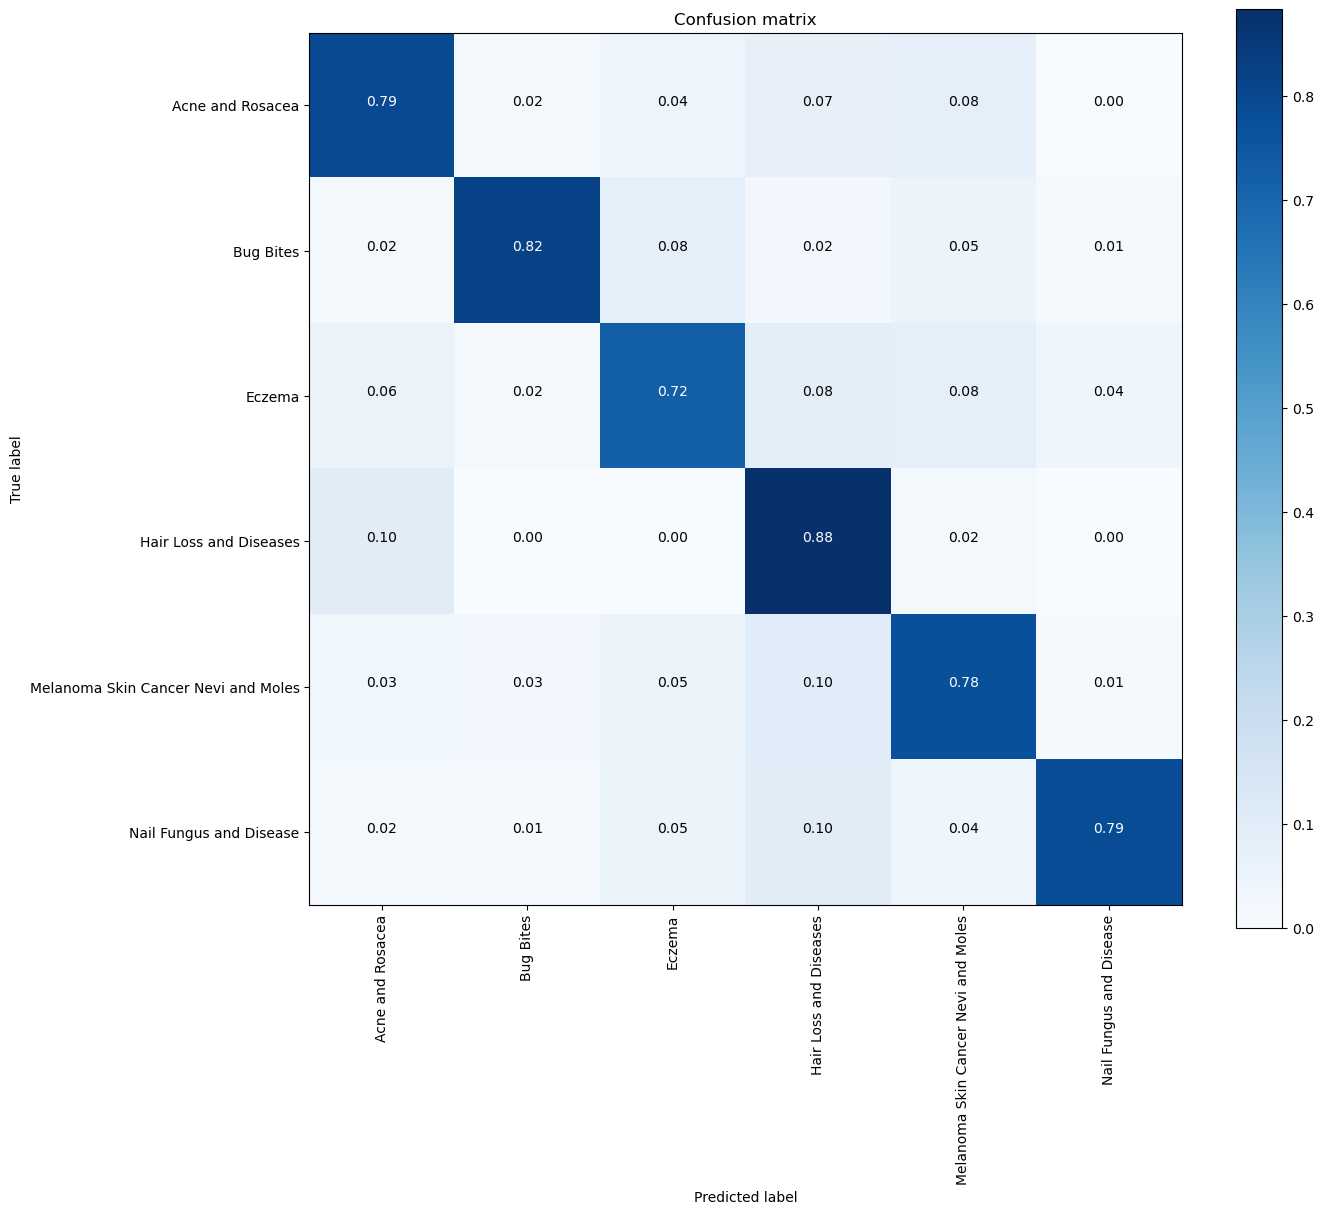

Classification Report:
                                     precision    recall  f1-score   support

                   Acne and Rosacea       0.86      0.79      0.83       312
                          Bug Bites       0.95      0.82      0.88       365
                             Eczema       0.78      0.72      0.75       309
             Hair Loss and Diseases       0.36      0.88      0.51        60
Melanoma Skin Cancer Nevi and Moles       0.54      0.78      0.64       116
            Nail Fungus and Disease       0.92      0.79      0.85       261

                           accuracy                           0.79      1423
                          macro avg       0.74      0.80      0.74      1423
                       weighted avg       0.83      0.79      0.80      1423



In [26]:
densenet_201= densenet_201.to(device)
predictions, labels = compute_metrics(densenet_201,test_data_loader, class_names)

In [30]:
#train_model(densenet_201, train_data_loader, test_data_loader, w_criterion, densenet_optimizer, densenet_scheduler, "densenet_nokfold", 50)

In [31]:
"""checkpoint = torch.load("densenet_nokfold_model_best_acc.pth.tar")
densenet_nokfold = models.densenet201()
densenet_ftr = densenet_nokfold.classifier.in_features
densenet_nokfold.classifier = nn.Linear(densenet_ftr, classes)
densenet_nokfold.load_state_dict(checkpoint['model'])
torch.save(densenet_nokfold,'densenet_nokfold.pth')"""

'checkpoint = torch.load("densenet_nokfold_model_best_acc.pth.tar")\ndensenet_nokfold = models.densenet201()\ndensenet_ftr = densenet_nokfold.classifier.in_features\ndensenet_nokfold.classifier = nn.Linear(densenet_ftr, classes)\ndensenet_nokfold.load_state_dict(checkpoint[\'model\'])\ntorch.save(densenet_nokfold,\'densenet_nokfold.pth\')'

In [32]:
"""densenet_nokfold= densenet_nokfold.to(device)
predictions, labels = compute_metrics(densenet_nokfold,test_data_loader, class_names)"""

'densenet_nokfold= densenet_nokfold.to(device)\npredictions, labels = compute_metrics(densenet_nokfold,test_data_loader, class_names)'

In [33]:
resnet_avg_accuracy = cross_validate(resnet_152, train_dataset, w_criterion, resnet_optimizer, resnet_scheduler, "resnet_152", 10, k_folds=5)

Training 5 folds for 10 epochs each
Fold 1/5
Epoch number 1


Loss: 1.118, Acc: 64.779%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 2516 out of 3884 images correctly (64.779%). Epoch loss: 1.118


Acc: 73.457%: 100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Testing Dataset got 714 out of 972 images correctly (73.457%).
=> new accuracy of 73.45679012345678 saved
Done
Epoch number 2


Loss: 0.794, Acc: 73.404%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 2851 out of 3884 images correctly (73.404%). Epoch loss: 0.794


Acc: 75.206%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 731 out of 972 images correctly (75.206%).
=> new accuracy of 75.20576131687243 saved
Done
Epoch number 3


Loss: 0.717, Acc: 75.875%: 100%|██████████| 122/122 [00:57<00:00,  2.14it/s]


Training Dataset got 2947 out of 3884 images correctly (75.875%). Epoch loss: 0.717


Acc: 75.309%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 732 out of 972 images correctly (75.309%).
=> new accuracy of 75.30864197530865 saved
Done
Epoch number 4


Loss: 0.651, Acc: 78.708%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3057 out of 3884 images correctly (78.708%). Epoch loss: 0.651


Acc: 77.366%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 752 out of 972 images correctly (77.366%).
=> new accuracy of 77.36625514403292 saved
Done
Epoch number 5


Loss: 0.592, Acc: 79.557%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3090 out of 3884 images correctly (79.557%). Epoch loss: 0.592


Acc: 78.395%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 762 out of 972 images correctly (78.395%).
=> new accuracy of 78.39506172839506 saved
Done
Epoch number 6


Loss: 0.580, Acc: 80.227%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3116 out of 3884 images correctly (80.227%). Epoch loss: 0.580


Acc: 79.733%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 775 out of 972 images correctly (79.733%).
=> new accuracy of 79.73251028806584 saved
Done
Epoch number 7


Loss: 0.567, Acc: 81.153%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3152 out of 3884 images correctly (81.153%). Epoch loss: 0.567


Acc: 78.704%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 765 out of 972 images correctly (78.704%).
Done
Epoch number 8


Loss: 0.545, Acc: 80.896%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3142 out of 3884 images correctly (80.896%). Epoch loss: 0.545


Acc: 79.527%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 773 out of 972 images correctly (79.527%).
Done
Epoch number 9


Loss: 0.530, Acc: 81.771%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3176 out of 3884 images correctly (81.771%). Epoch loss: 0.530


Acc: 79.115%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 769 out of 972 images correctly (79.115%).
Done
Epoch number 10


Loss: 0.527, Acc: 82.235%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3194 out of 3884 images correctly (82.235%). Epoch loss: 0.527


Acc: 78.601%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 764 out of 972 images correctly (78.601%).
Done


Acc: 77.469%: 100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Testing Dataset got 753 out of 972 images correctly (77.469%).
Fold 2/5
Epoch number 1


Loss: 0.541, Acc: 81.544%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3168 out of 3885 images correctly (81.544%). Epoch loss: 0.541


Acc: 83.333%:  97%|█████████▋| 30/31 [00:13<00:00,  2.21it/s]C:\Users\SAMU\anaconda3\envs\dermanet-env\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Acc: 83.316%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 809 out of 971 images correctly (83.316%).
=> new accuracy of 83.31616889804326 saved
Done
Epoch number 2


Loss: 0.537, Acc: 81.673%: 100%|██████████| 122/122 [00:56<00:00,  2.14it/s]


Training Dataset got 3173 out of 3885 images correctly (81.673%). Epoch loss: 0.537


Acc: 83.110%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 807 out of 971 images correctly (83.110%).
Done
Epoch number 3


Loss: 0.536, Acc: 82.291%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3197 out of 3885 images correctly (82.291%). Epoch loss: 0.536


Acc: 81.977%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 796 out of 971 images correctly (81.977%).
Done
Epoch number 4


Loss: 0.532, Acc: 82.136%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3191 out of 3885 images correctly (82.136%). Epoch loss: 0.532


Acc: 84.243%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 818 out of 971 images correctly (84.243%).
=> new accuracy of 84.24304840370752 saved
Done
Epoch number 5


Loss: 0.522, Acc: 82.883%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3220 out of 3885 images correctly (82.883%). Epoch loss: 0.522


Acc: 83.522%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 811 out of 971 images correctly (83.522%).
Done
Epoch number 6


Loss: 0.530, Acc: 82.342%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3199 out of 3885 images correctly (82.342%). Epoch loss: 0.530


Acc: 82.801%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 804 out of 971 images correctly (82.801%).
Done
Epoch number 7


Loss: 0.529, Acc: 81.931%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3183 out of 3885 images correctly (81.931%). Epoch loss: 0.529


Acc: 82.801%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 804 out of 971 images correctly (82.801%).
Done
Epoch number 8


Loss: 0.529, Acc: 82.394%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3201 out of 3885 images correctly (82.394%). Epoch loss: 0.529


Acc: 81.565%: 100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Testing Dataset got 792 out of 971 images correctly (81.565%).
Done
Epoch number 9


Loss: 0.523, Acc: 82.651%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3211 out of 3885 images correctly (82.651%). Epoch loss: 0.523


Acc: 83.625%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 812 out of 971 images correctly (83.625%).
Done
Epoch number 10


Loss: 0.511, Acc: 82.677%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3212 out of 3885 images correctly (82.677%). Epoch loss: 0.511


Acc: 82.080%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 797 out of 971 images correctly (82.080%).
Done


Acc: 83.213%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 808 out of 971 images correctly (83.213%).
Fold 3/5
Epoch number 1


Loss: 0.531, Acc: 82.728%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3214 out of 3885 images correctly (82.728%). Epoch loss: 0.531


Acc: 84.861%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 824 out of 971 images correctly (84.861%).
=> new accuracy of 84.86096807415036 saved
Done
Epoch number 2


Loss: 0.527, Acc: 81.853%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3180 out of 3885 images correctly (81.853%). Epoch loss: 0.527


Acc: 83.728%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 813 out of 971 images correctly (83.728%).
Done
Epoch number 3


Loss: 0.521, Acc: 82.188%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3193 out of 3885 images correctly (82.188%). Epoch loss: 0.521


Acc: 84.758%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 823 out of 971 images correctly (84.758%).
Done
Epoch number 4


Loss: 0.531, Acc: 81.570%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3169 out of 3885 images correctly (81.570%). Epoch loss: 0.531


Acc: 84.861%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 824 out of 971 images correctly (84.861%).
Done
Epoch number 5


Loss: 0.524, Acc: 81.467%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3165 out of 3885 images correctly (81.467%). Epoch loss: 0.524


Acc: 83.522%: 100%|██████████| 31/31 [00:14<00:00,  2.21it/s]


Testing Dataset got 811 out of 971 images correctly (83.522%).
Done
Epoch number 6


Loss: 0.522, Acc: 82.497%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3205 out of 3885 images correctly (82.497%). Epoch loss: 0.522


Acc: 84.758%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 823 out of 971 images correctly (84.758%).
Done
Epoch number 7


Loss: 0.521, Acc: 81.467%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3165 out of 3885 images correctly (81.467%). Epoch loss: 0.521


Acc: 83.110%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 807 out of 971 images correctly (83.110%).
Done
Epoch number 8


Loss: 0.529, Acc: 82.317%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3198 out of 3885 images correctly (82.317%). Epoch loss: 0.529


Acc: 83.831%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 814 out of 971 images correctly (83.831%).
Done
Epoch number 9


Loss: 0.532, Acc: 81.158%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3153 out of 3885 images correctly (81.158%). Epoch loss: 0.532


Acc: 84.140%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 817 out of 971 images correctly (84.140%).
Done
Epoch number 10


Loss: 0.536, Acc: 81.905%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3182 out of 3885 images correctly (81.905%). Epoch loss: 0.536


Acc: 83.934%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 815 out of 971 images correctly (83.934%).
Done


Acc: 84.861%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 824 out of 971 images correctly (84.861%).
Fold 4/5
Epoch number 1


Loss: 0.519, Acc: 82.033%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3187 out of 3885 images correctly (82.033%). Epoch loss: 0.519


Acc: 85.170%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 827 out of 971 images correctly (85.170%).
=> new accuracy of 85.16992790937178 saved
Done
Epoch number 2


Loss: 0.515, Acc: 83.218%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3233 out of 3885 images correctly (83.218%). Epoch loss: 0.515


Acc: 84.758%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 823 out of 971 images correctly (84.758%).
Done
Epoch number 3


Loss: 0.522, Acc: 81.853%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3180 out of 3885 images correctly (81.853%). Epoch loss: 0.522


Acc: 86.303%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 838 out of 971 images correctly (86.303%).
=> new accuracy of 86.30278063851699 saved
Done
Epoch number 4


Loss: 0.517, Acc: 82.342%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3199 out of 3885 images correctly (82.342%). Epoch loss: 0.517


Acc: 84.449%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 820 out of 971 images correctly (84.449%).
Done
Epoch number 5


Loss: 0.535, Acc: 82.008%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3186 out of 3885 images correctly (82.008%). Epoch loss: 0.535


Acc: 83.213%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 808 out of 971 images correctly (83.213%).
Done
Epoch number 6


Loss: 0.533, Acc: 81.750%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3176 out of 3885 images correctly (81.750%). Epoch loss: 0.533


Acc: 85.376%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 829 out of 971 images correctly (85.376%).
Done
Epoch number 7


Loss: 0.517, Acc: 82.214%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3194 out of 3885 images correctly (82.214%). Epoch loss: 0.517


Acc: 85.788%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 833 out of 971 images correctly (85.788%).
Done
Epoch number 8


Loss: 0.521, Acc: 81.931%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3183 out of 3885 images correctly (81.931%). Epoch loss: 0.521


Acc: 83.625%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 812 out of 971 images correctly (83.625%).
Done
Epoch number 9


Loss: 0.524, Acc: 81.905%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3182 out of 3885 images correctly (81.905%). Epoch loss: 0.524


Acc: 84.037%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 816 out of 971 images correctly (84.037%).
Done
Epoch number 10


Loss: 0.537, Acc: 81.519%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3167 out of 3885 images correctly (81.519%). Epoch loss: 0.537


Acc: 84.140%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 817 out of 971 images correctly (84.140%).
Done


Acc: 86.818%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 843 out of 971 images correctly (86.818%).
Fold 5/5
Epoch number 1


Loss: 0.528, Acc: 82.317%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3198 out of 3885 images correctly (82.317%). Epoch loss: 0.528


Acc: 85.479%: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Testing Dataset got 830 out of 971 images correctly (85.479%).
=> new accuracy of 85.47888774459321 saved
Done
Epoch number 2


Loss: 0.526, Acc: 81.750%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3176 out of 3885 images correctly (81.750%). Epoch loss: 0.526


Acc: 85.376%: 100%|██████████| 31/31 [00:13<00:00,  2.26it/s]


Testing Dataset got 829 out of 971 images correctly (85.376%).
Done
Epoch number 3


Loss: 0.527, Acc: 82.239%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3195 out of 3885 images correctly (82.239%). Epoch loss: 0.527


Acc: 84.037%: 100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Testing Dataset got 816 out of 971 images correctly (84.037%).
Done
Epoch number 4


Loss: 0.527, Acc: 81.030%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3148 out of 3885 images correctly (81.030%). Epoch loss: 0.527


Acc: 86.303%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 838 out of 971 images correctly (86.303%).
=> new accuracy of 86.30278063851699 saved
Done
Epoch number 5


Loss: 0.520, Acc: 81.287%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3158 out of 3885 images correctly (81.287%). Epoch loss: 0.520


Acc: 85.273%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 828 out of 971 images correctly (85.273%).
Done
Epoch number 6


Loss: 0.524, Acc: 82.136%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3191 out of 3885 images correctly (82.136%). Epoch loss: 0.524


Acc: 84.037%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 816 out of 971 images correctly (84.037%).
Done
Epoch number 7


Loss: 0.530, Acc: 82.523%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3206 out of 3885 images correctly (82.523%). Epoch loss: 0.530


Acc: 85.582%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 831 out of 971 images correctly (85.582%).
Done
Epoch number 8


Loss: 0.526, Acc: 82.239%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3195 out of 3885 images correctly (82.239%). Epoch loss: 0.526


Acc: 85.170%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Testing Dataset got 827 out of 971 images correctly (85.170%).
Done
Epoch number 9


Loss: 0.531, Acc: 81.467%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3165 out of 3885 images correctly (81.467%). Epoch loss: 0.531


Acc: 84.552%: 100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Testing Dataset got 821 out of 971 images correctly (84.552%).
Done
Epoch number 10


Loss: 0.530, Acc: 81.879%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3181 out of 3885 images correctly (81.879%). Epoch loss: 0.530


Acc: 85.994%: 100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Testing Dataset got 835 out of 971 images correctly (85.994%).
Done


Acc: 85.582%: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]

Testing Dataset got 831 out of 971 images correctly (85.582%).
Average accuracy across 5 folds: 83.589


In [ ]:
checkpoint = torch.load("resnet_152_model_best_acc.pth.tar")
resnet_152 = models.resnet152()
resnet_ftr = resnet_152.fc.in_features
resnet_152.fc = nn.Linear(resnet_ftr,classes)
resnet_152.load_state_dict(checkpoint['model'])
torch.save(resnet_152,'resnet_152.pth')

In [26]:
resnet_152 = torch.load('resnet_152.pth')

Normalized confusion matrix


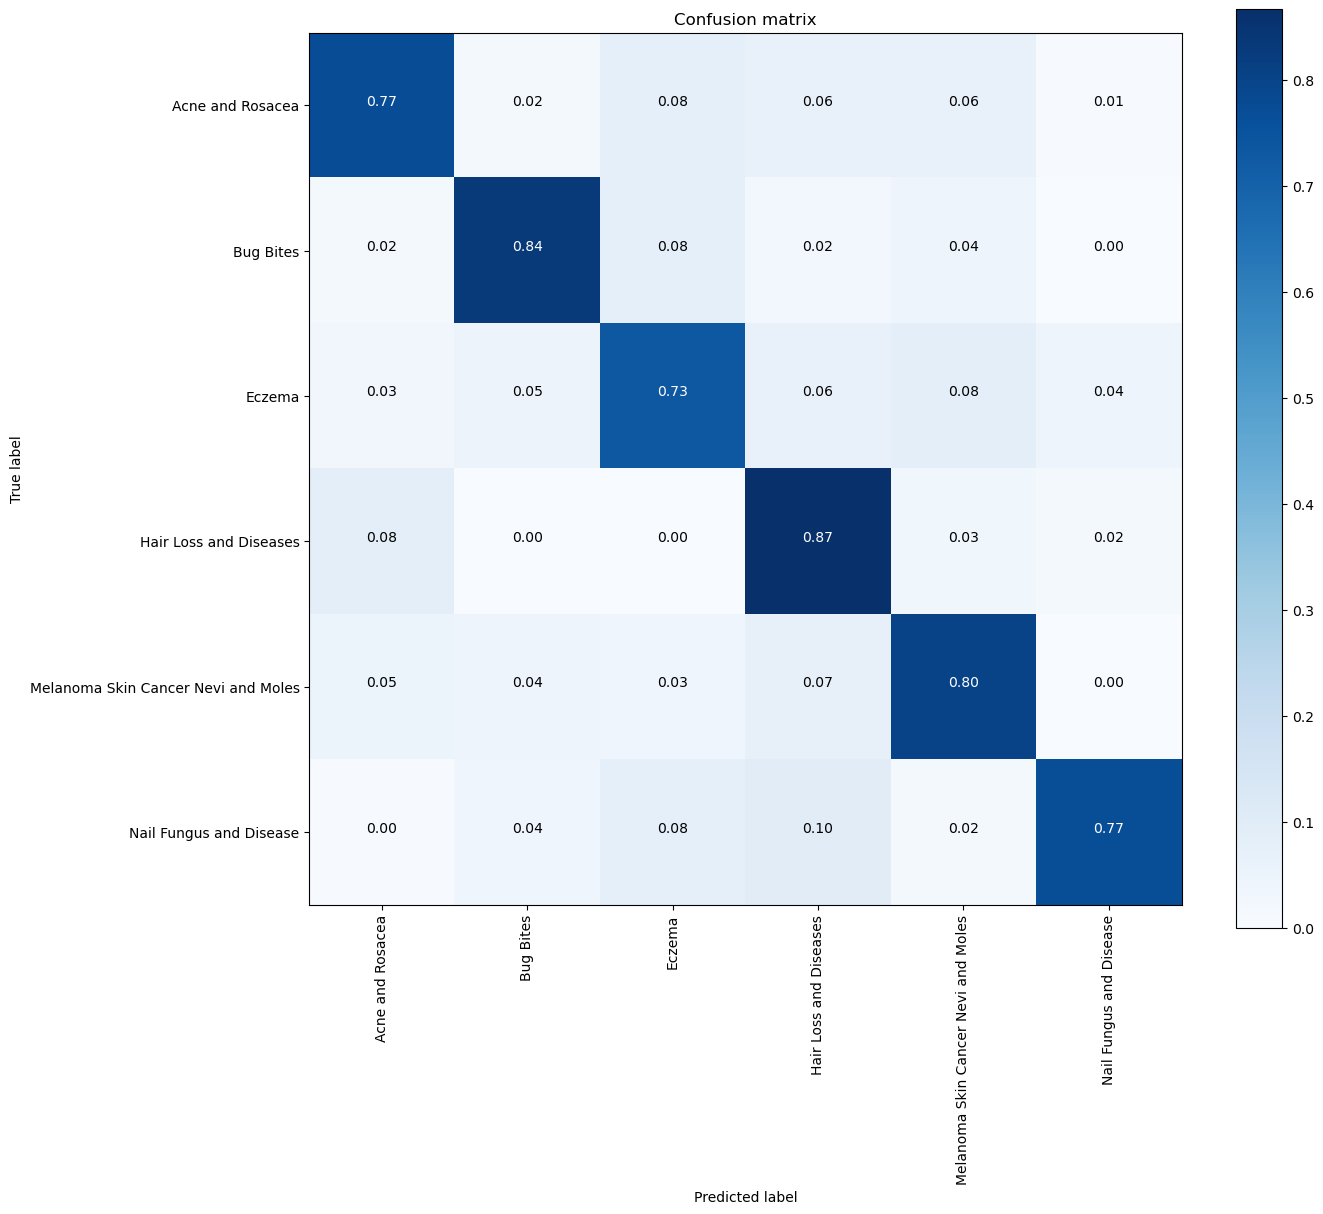

Classification Report:
                                     precision    recall  f1-score   support

                   Acne and Rosacea       0.90      0.77      0.83       312
                          Bug Bites       0.90      0.84      0.87       365
                             Eczema       0.74      0.73      0.74       309
             Hair Loss and Diseases       0.39      0.87      0.54        60
Melanoma Skin Cancer Nevi and Moles       0.58      0.80      0.67       116
            Nail Fungus and Disease       0.93      0.77      0.84       261

                           accuracy                           0.78      1423
                          macro avg       0.74      0.80      0.75      1423
                       weighted avg       0.82      0.78      0.79      1423



In [28]:
resnet_152 = resnet_152.to(device)
predictions, labels = compute_metrics(resnet_152,test_data_loader, class_names)

In [37]:
vgg_avg_accuracy = cross_validate(vgg_19, train_dataset, w_criterion, vgg_optimizer, vgg_scheduler ,"vgg_19", 10, k_folds=5)

Training 5 folds for 10 epochs each
Fold 1/5
Epoch number 1


Loss: 1.389, Acc: 58.599%: 100%|██████████| 122/122 [00:57<00:00,  2.14it/s]


Training Dataset got 2276 out of 3884 images correctly (58.599%). Epoch loss: 1.389


Acc: 62.037%: 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Testing Dataset got 603 out of 972 images correctly (62.037%).
=> new accuracy of 62.03703703703704 saved
Done
Epoch number 2


Loss: 1.176, Acc: 66.632%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 2588 out of 3884 images correctly (66.632%). Epoch loss: 1.176


Acc: 69.753%: 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Testing Dataset got 678 out of 972 images correctly (69.753%).
=> new accuracy of 69.75308641975309 saved
Done
Epoch number 3


Loss: 1.096, Acc: 69.310%: 100%|██████████| 122/122 [00:57<00:00,  2.14it/s]


Training Dataset got 2692 out of 3884 images correctly (69.310%). Epoch loss: 1.096


Acc: 69.239%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 673 out of 972 images correctly (69.239%).
Done
Epoch number 4


Loss: 1.026, Acc: 71.936%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 2794 out of 3884 images correctly (71.936%). Epoch loss: 1.026


Acc: 72.737%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 707 out of 972 images correctly (72.737%).
=> new accuracy of 72.73662551440329 saved
Done
Epoch number 5


Loss: 0.715, Acc: 77.163%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 2997 out of 3884 images correctly (77.163%). Epoch loss: 0.715


Acc: 75.412%: 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


Testing Dataset got 733 out of 972 images correctly (75.412%).
=> new accuracy of 75.41152263374485 saved
Done
Epoch number 6


Loss: 0.661, Acc: 80.433%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3124 out of 3884 images correctly (80.433%). Epoch loss: 0.661


Acc: 77.984%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 758 out of 972 images correctly (77.984%).
=> new accuracy of 77.98353909465021 saved
Done
Epoch number 7


Loss: 0.543, Acc: 81.540%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3167 out of 3884 images correctly (81.540%). Epoch loss: 0.543


Acc: 76.852%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 747 out of 972 images correctly (76.852%).
Done
Epoch number 8


Loss: 0.435, Acc: 85.711%: 100%|██████████| 122/122 [00:56<00:00,  2.14it/s]


Training Dataset got 3329 out of 3884 images correctly (85.711%). Epoch loss: 0.435


Acc: 78.292%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 761 out of 972 images correctly (78.292%).
=> new accuracy of 78.29218106995884 saved
Done
Epoch number 9


Loss: 0.378, Acc: 87.539%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3400 out of 3884 images correctly (87.539%). Epoch loss: 0.378


Acc: 80.967%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 787 out of 972 images correctly (80.967%).
=> new accuracy of 80.96707818930041 saved
Done
Epoch number 10


Loss: 0.363, Acc: 88.208%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3426 out of 3884 images correctly (88.208%). Epoch loss: 0.363


Acc: 79.733%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 775 out of 972 images correctly (79.733%).
Done


Acc: 77.778%: 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


Testing Dataset got 756 out of 972 images correctly (77.778%).
Fold 2/5
Epoch number 1


Loss: 0.490, Acc: 86.332%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3354 out of 3885 images correctly (86.332%). Epoch loss: 0.490


Acc: 91.452%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 888 out of 971 images correctly (91.452%).
=> new accuracy of 91.45211122554068 saved
Done
Epoch number 2


Loss: 0.379, Acc: 87.773%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3410 out of 3885 images correctly (87.773%). Epoch loss: 0.379


Acc: 91.864%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 892 out of 971 images correctly (91.864%).
=> new accuracy of 91.86405767250257 saved
Done
Epoch number 3


Loss: 0.337, Acc: 88.160%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3425 out of 3885 images correctly (88.160%). Epoch loss: 0.337


Acc: 92.070%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 894 out of 971 images correctly (92.070%).
=> new accuracy of 92.07003089598352 saved
Done
Epoch number 4


Loss: 0.311, Acc: 90.013%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3497 out of 3885 images correctly (90.013%). Epoch loss: 0.311


Acc: 91.555%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 889 out of 971 images correctly (91.555%).
Done
Epoch number 5


Loss: 0.279, Acc: 90.914%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3532 out of 3885 images correctly (90.914%). Epoch loss: 0.279


Acc: 92.894%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 902 out of 971 images correctly (92.894%).
=> new accuracy of 92.89392378990732 saved
Done
Epoch number 6


Loss: 0.262, Acc: 90.940%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3533 out of 3885 images correctly (90.940%). Epoch loss: 0.262


Acc: 92.482%: 100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


Testing Dataset got 898 out of 971 images correctly (92.482%).
Done
Epoch number 7


Loss: 0.249, Acc: 90.837%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3529 out of 3885 images correctly (90.837%). Epoch loss: 0.249


Acc: 91.555%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 889 out of 971 images correctly (91.555%).
Done
Epoch number 8


Loss: 0.260, Acc: 90.759%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3526 out of 3885 images correctly (90.759%). Epoch loss: 0.260


Acc: 92.688%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 900 out of 971 images correctly (92.688%).
Done
Epoch number 9


Loss: 0.244, Acc: 91.480%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3554 out of 3885 images correctly (91.480%). Epoch loss: 0.244


Acc: 92.791%: 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Testing Dataset got 901 out of 971 images correctly (92.791%).
Done
Epoch number 10


Loss: 0.212, Acc: 92.124%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3579 out of 3885 images correctly (92.124%). Epoch loss: 0.212


Acc: 92.173%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 895 out of 971 images correctly (92.173%).
Done


Acc: 91.761%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 891 out of 971 images correctly (91.761%).
Fold 3/5
Epoch number 1


Loss: 0.256, Acc: 91.171%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3542 out of 3885 images correctly (91.171%). Epoch loss: 0.256


Acc: 96.087%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 933 out of 971 images correctly (96.087%).
=> new accuracy of 96.08650875386199 saved
Done
Epoch number 2


Loss: 0.257, Acc: 91.429%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3552 out of 3885 images correctly (91.429%). Epoch loss: 0.257


Acc: 96.498%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 937 out of 971 images correctly (96.498%).
=> new accuracy of 96.4984552008239 saved
Done
Epoch number 3


Loss: 0.248, Acc: 91.094%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3539 out of 3885 images correctly (91.094%). Epoch loss: 0.248


Acc: 96.704%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 939 out of 971 images correctly (96.704%).
=> new accuracy of 96.70442842430484 saved
Done
Epoch number 4


Loss: 0.259, Acc: 90.965%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3534 out of 3885 images correctly (90.965%). Epoch loss: 0.259


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Done
Epoch number 5


Loss: 0.240, Acc: 91.403%: 100%|██████████| 122/122 [00:55<00:00,  2.18it/s]


Training Dataset got 3551 out of 3885 images correctly (91.403%). Epoch loss: 0.240


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Done
Epoch number 6


Loss: 0.259, Acc: 90.837%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3529 out of 3885 images correctly (90.837%). Epoch loss: 0.259


Acc: 96.087%: 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Testing Dataset got 933 out of 971 images correctly (96.087%).
Done
Epoch number 7


Loss: 0.248, Acc: 91.377%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3550 out of 3885 images correctly (91.377%). Epoch loss: 0.248


Acc: 96.601%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 938 out of 971 images correctly (96.601%).
Done
Epoch number 8


Loss: 0.253, Acc: 91.763%: 100%|██████████| 122/122 [00:55<00:00,  2.18it/s]


Training Dataset got 3565 out of 3885 images correctly (91.763%). Epoch loss: 0.253


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Done
Epoch number 9


Loss: 0.240, Acc: 91.197%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3543 out of 3885 images correctly (91.197%). Epoch loss: 0.240


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.50it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Done
Epoch number 10


Loss: 0.234, Acc: 91.866%: 100%|██████████| 122/122 [00:55<00:00,  2.18it/s]


Training Dataset got 3569 out of 3885 images correctly (91.866%). Epoch loss: 0.234


Acc: 96.395%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 936 out of 971 images correctly (96.395%).
Done


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Fold 4/5
Epoch number 1


Loss: 0.241, Acc: 91.377%: 100%|██████████| 122/122 [00:56<00:00,  2.18it/s]


Training Dataset got 3550 out of 3885 images correctly (91.377%). Epoch loss: 0.241


Acc: 96.292%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 935 out of 971 images correctly (96.292%).
=> new accuracy of 96.29248197734294 saved
Done
Epoch number 2


Loss: 0.248, Acc: 91.377%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3550 out of 3885 images correctly (91.377%). Epoch loss: 0.248


Acc: 96.087%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 933 out of 971 images correctly (96.087%).
Done
Epoch number 3


Loss: 0.218, Acc: 92.175%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3581 out of 3885 images correctly (92.175%). Epoch loss: 0.218


Acc: 95.984%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 932 out of 971 images correctly (95.984%).
Done
Epoch number 4


Loss: 0.235, Acc: 91.351%: 100%|██████████| 122/122 [00:56<00:00,  2.18it/s]


Training Dataset got 3549 out of 3885 images correctly (91.351%). Epoch loss: 0.235


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Done
Epoch number 5


Loss: 0.250, Acc: 91.223%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3544 out of 3885 images correctly (91.223%). Epoch loss: 0.250


Acc: 96.087%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 933 out of 971 images correctly (96.087%).
Done
Epoch number 6


Loss: 0.255, Acc: 91.223%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3544 out of 3885 images correctly (91.223%). Epoch loss: 0.255


Acc: 95.366%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 926 out of 971 images correctly (95.366%).
Done
Epoch number 7


Loss: 0.240, Acc: 91.429%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3552 out of 3885 images correctly (91.429%). Epoch loss: 0.240


Acc: 96.087%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 933 out of 971 images correctly (96.087%).
Done
Epoch number 8


Loss: 0.255, Acc: 91.377%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3550 out of 3885 images correctly (91.377%). Epoch loss: 0.255


Acc: 96.395%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 936 out of 971 images correctly (96.395%).
=> new accuracy of 96.39546858908342 saved
Done
Epoch number 9


Loss: 0.238, Acc: 91.145%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3541 out of 3885 images correctly (91.145%). Epoch loss: 0.238


Acc: 95.881%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 931 out of 971 images correctly (95.881%).
Done
Epoch number 10


Loss: 0.226, Acc: 91.609%: 100%|██████████| 122/122 [00:56<00:00,  2.18it/s]


Training Dataset got 3559 out of 3885 images correctly (91.609%). Epoch loss: 0.226


Acc: 96.704%: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Testing Dataset got 939 out of 971 images correctly (96.704%).
=> new accuracy of 96.70442842430484 saved
Done


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Fold 5/5
Epoch number 1


Loss: 0.239, Acc: 91.145%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3541 out of 3885 images correctly (91.145%). Epoch loss: 0.239


Acc: 96.087%: 100%|██████████| 31/31 [00:12<00:00,  2.54it/s]


Testing Dataset got 933 out of 971 images correctly (96.087%).
=> new accuracy of 96.08650875386199 saved
Done
Epoch number 2


Loss: 0.234, Acc: 92.149%: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


Training Dataset got 3580 out of 3885 images correctly (92.149%). Epoch loss: 0.234


Acc: 96.292%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 935 out of 971 images correctly (96.292%).
=> new accuracy of 96.29248197734294 saved
Done
Epoch number 3


Loss: 0.244, Acc: 90.991%: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


Training Dataset got 3535 out of 3885 images correctly (90.991%). Epoch loss: 0.244


Acc: 96.395%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 936 out of 971 images correctly (96.395%).
=> new accuracy of 96.39546858908342 saved
Done
Epoch number 4


Loss: 0.234, Acc: 91.737%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3564 out of 3885 images correctly (91.737%). Epoch loss: 0.234


Acc: 96.292%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 935 out of 971 images correctly (96.292%).
Done
Epoch number 5


Loss: 0.255, Acc: 91.042%: 100%|██████████| 122/122 [00:55<00:00,  2.18it/s]


Training Dataset got 3537 out of 3885 images correctly (91.042%). Epoch loss: 0.255


Acc: 96.395%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 936 out of 971 images correctly (96.395%).
Done
Epoch number 6


Loss: 0.240, Acc: 90.991%: 100%|██████████| 122/122 [00:56<00:00,  2.18it/s]


Training Dataset got 3535 out of 3885 images correctly (90.991%). Epoch loss: 0.240


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Done
Epoch number 7


Loss: 0.222, Acc: 91.969%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3573 out of 3885 images correctly (91.969%). Epoch loss: 0.222


Acc: 96.807%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 940 out of 971 images correctly (96.807%).
=> new accuracy of 96.80741503604531 saved
Done
Epoch number 8


Loss: 0.259, Acc: 91.300%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3547 out of 3885 images correctly (91.300%). Epoch loss: 0.259


Acc: 96.292%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


Testing Dataset got 935 out of 971 images correctly (96.292%).
Done
Epoch number 9


Loss: 0.240, Acc: 91.789%: 100%|██████████| 122/122 [00:56<00:00,  2.17it/s]


Training Dataset got 3566 out of 3885 images correctly (91.789%). Epoch loss: 0.240


Acc: 95.881%: 100%|██████████| 31/31 [00:12<00:00,  2.48it/s]


Testing Dataset got 931 out of 971 images correctly (95.881%).
Done
Epoch number 10


Loss: 0.246, Acc: 92.072%: 100%|██████████| 122/122 [00:56<00:00,  2.18it/s]


Training Dataset got 3577 out of 3885 images correctly (92.072%). Epoch loss: 0.246


Acc: 96.189%: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Testing Dataset got 934 out of 971 images correctly (96.189%).
Done


Acc: 96.395%: 100%|██████████| 31/31 [00:12<00:00,  2.51it/s]

Testing Dataset got 936 out of 971 images correctly (96.395%).
Average accuracy across 5 folds: 91.663


In [39]:
checkpoint = torch.load("vgg_19_model_best_acc.pth.tar")
vgg_19 = models.vgg19()
vgg_19.classifier[6] = nn.Linear(vgg_19.classifier[6].in_features, classes)
vgg_ftr = vgg_19.classifier[6].in_features
vgg_19.fc = nn.Linear(vgg_ftr,classes)
vgg_19.load_state_dict(checkpoint['model'])
torch.save(vgg_19,'vgg_19.pth')

In [27]:
vgg_19 = torch.load("vgg_19.pth")

C:\Users\SAMU\anaconda3\envs\dermanet-env\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 2.20 GiB. GPU  (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


Normalized confusion matrix


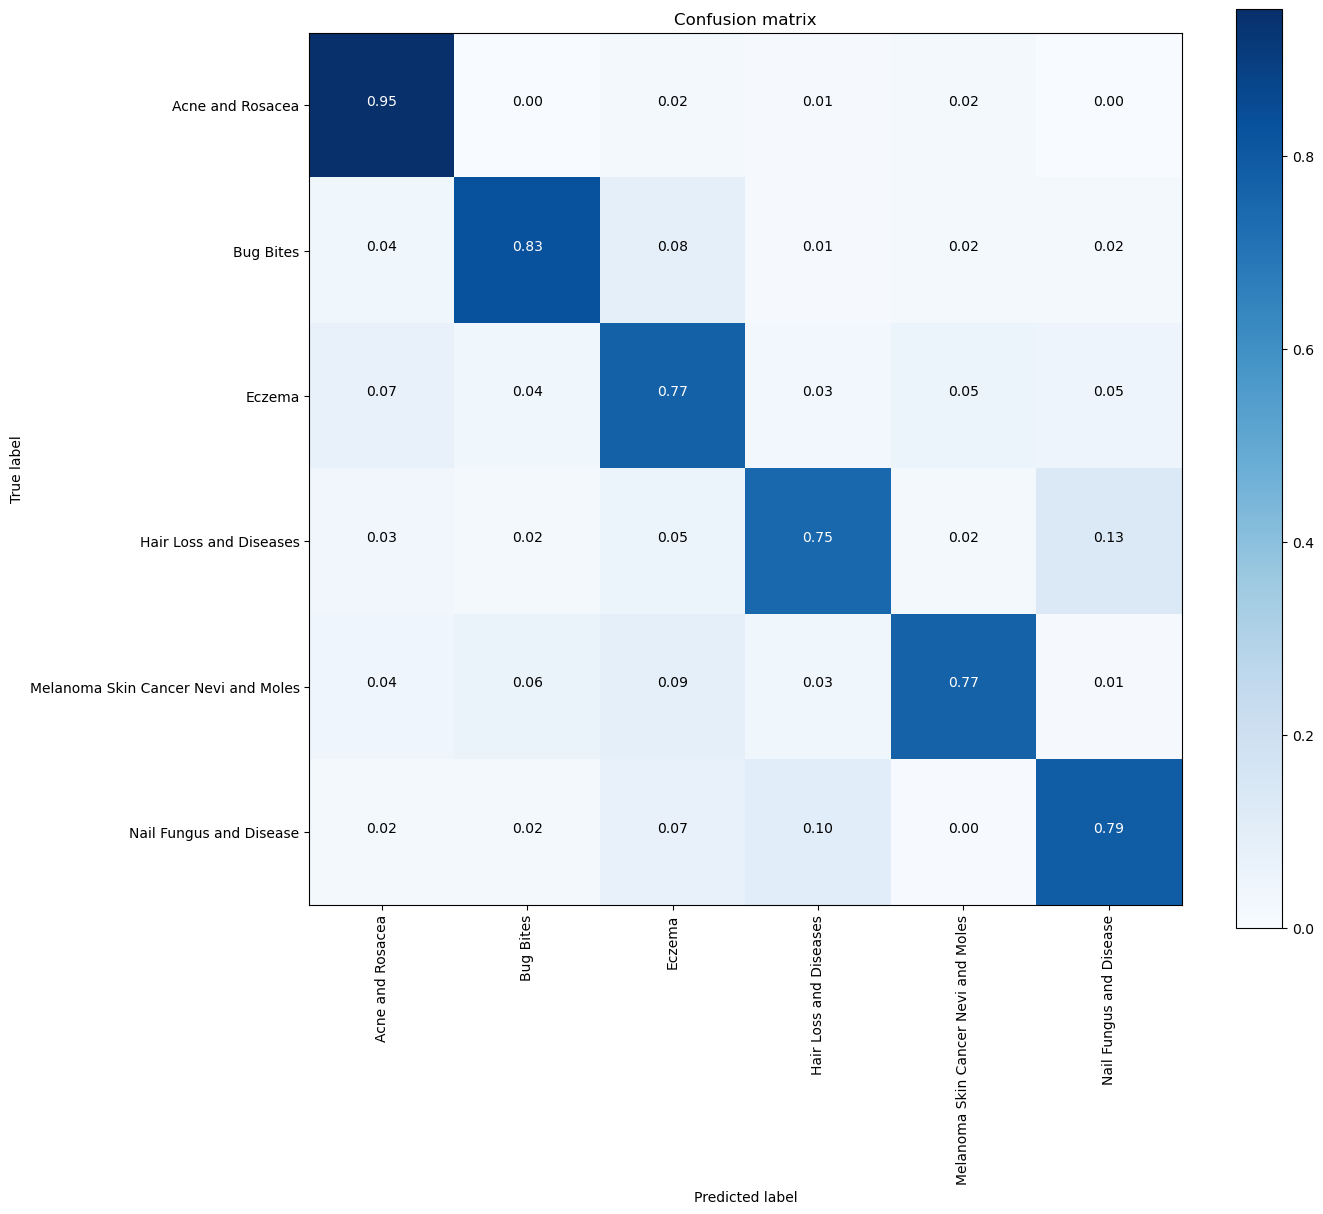

Classification Report:
                                     precision    recall  f1-score   support

                   Acne and Rosacea       0.86      0.95      0.91       312
                          Bug Bites       0.93      0.83      0.88       365
                             Eczema       0.78      0.77      0.77       309
             Hair Loss and Diseases       0.49      0.75      0.59        60
Melanoma Skin Cancer Nevi and Moles       0.74      0.77      0.75       116
            Nail Fungus and Disease       0.88      0.79      0.83       261

                           accuracy                           0.83      1423
                          macro avg       0.78      0.81      0.79      1423
                       weighted avg       0.84      0.83      0.83      1423



In [30]:
vgg_19 = vgg_19.to(device)
predictions, labels = compute_metrics(vgg_19, test_data_loader, class_names)

In [88]:
densenet_201 = torch.load("densenet_201.pth").to(device)
resnet_152 = torch.load("resnet_152.pth").to(device)
vgg_19 = torch.load("vgg_19.pth").to(device)

In [89]:
ensemble_model = EnsembleModel(densenet_201, resnet_152, vgg_19, num_classes=6).to(device)
torch.save(ensemble_model, 'ensemble_model.pth')

Normalized confusion matrix


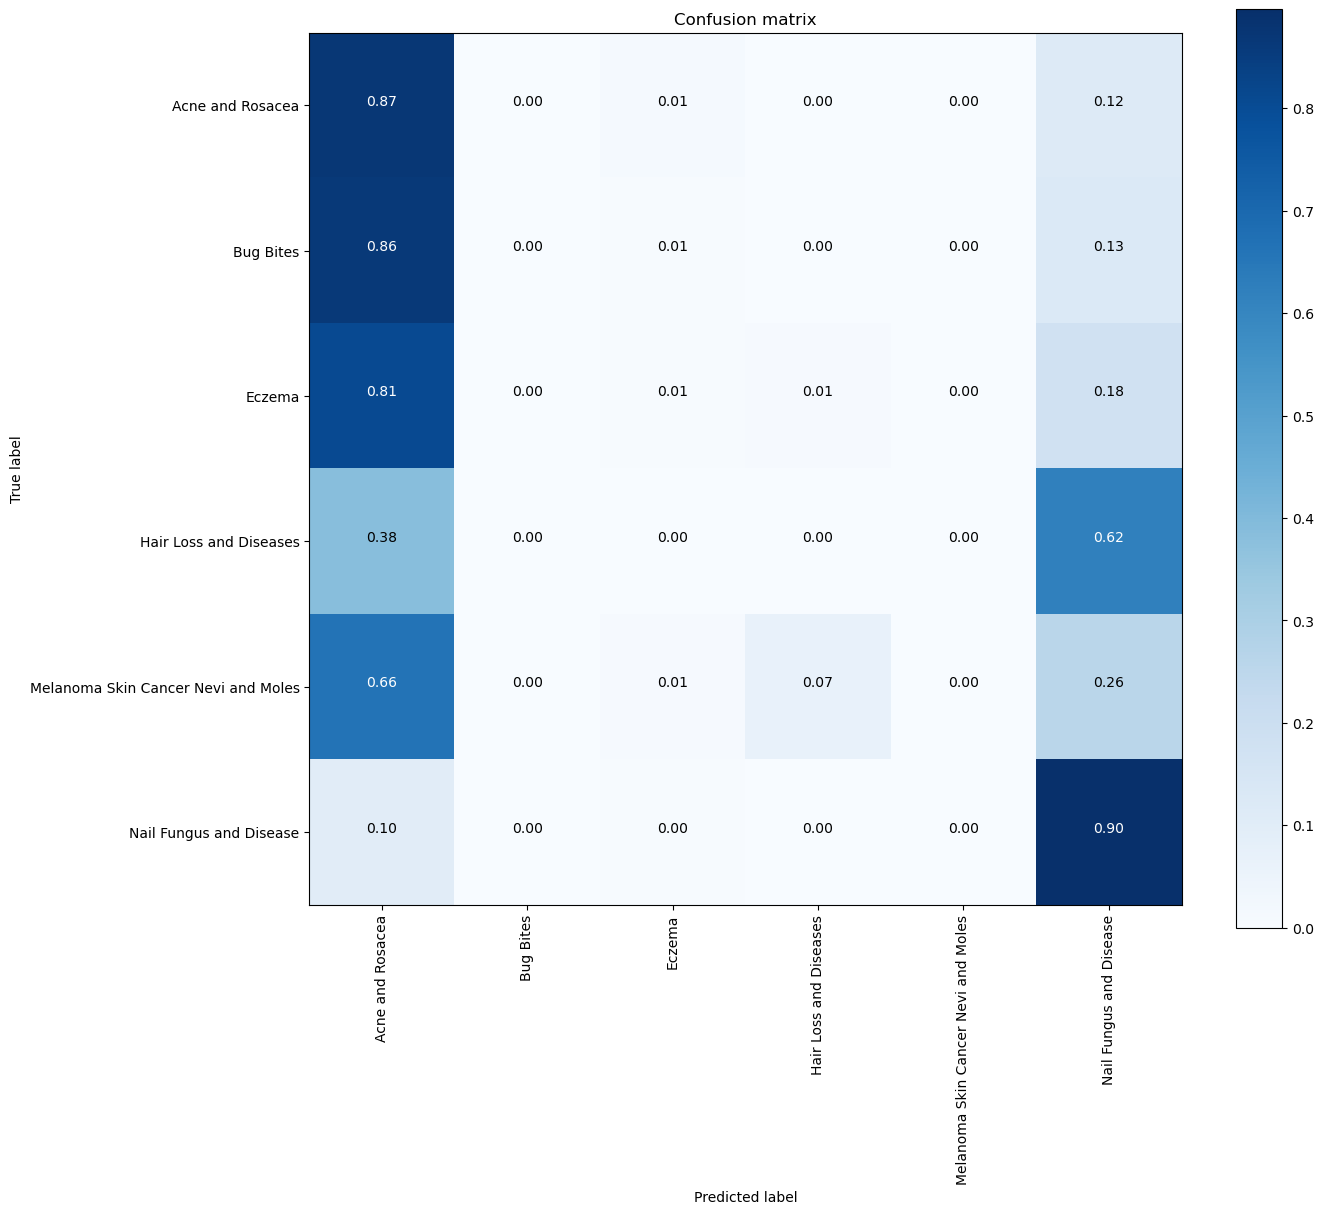

Classification Report:
                                     precision    recall  f1-score   support

                   Acne and Rosacea       0.28      0.87      0.43       312
                          Bug Bites       0.00      0.00      0.00       365
                             Eczema       0.20      0.01      0.01       309
             Hair Loss and Diseases       0.00      0.00      0.00        60
Melanoma Skin Cancer Nevi and Moles       0.00      0.00      0.00       116
            Nail Fungus and Disease       0.53      0.90      0.67       261

                           accuracy                           0.36      1423
                          macro avg       0.17      0.30      0.18      1423
                       weighted avg       0.20      0.36      0.22      1423



C:\Users\SAMU\anaconda3\envs\dermanet-env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAMU\anaconda3\envs\dermanet-env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SAMU\anaconda3\envs\dermanet-env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [94]:
predictions, labels = compute_metrics_ensemble(ensemble_model, test_data_loader, class_names)

In [95]:
m_1 = torch.load("densenet_201.pth")
m_2 = torch.load("resnet_152.pth")
m_3 = torch.load("vgg_19.pth")

m_1.eval()
m_2.eval()
m_3.eval()

n_models = [m_1, m_2, m_3]

Normalized confusion matrix


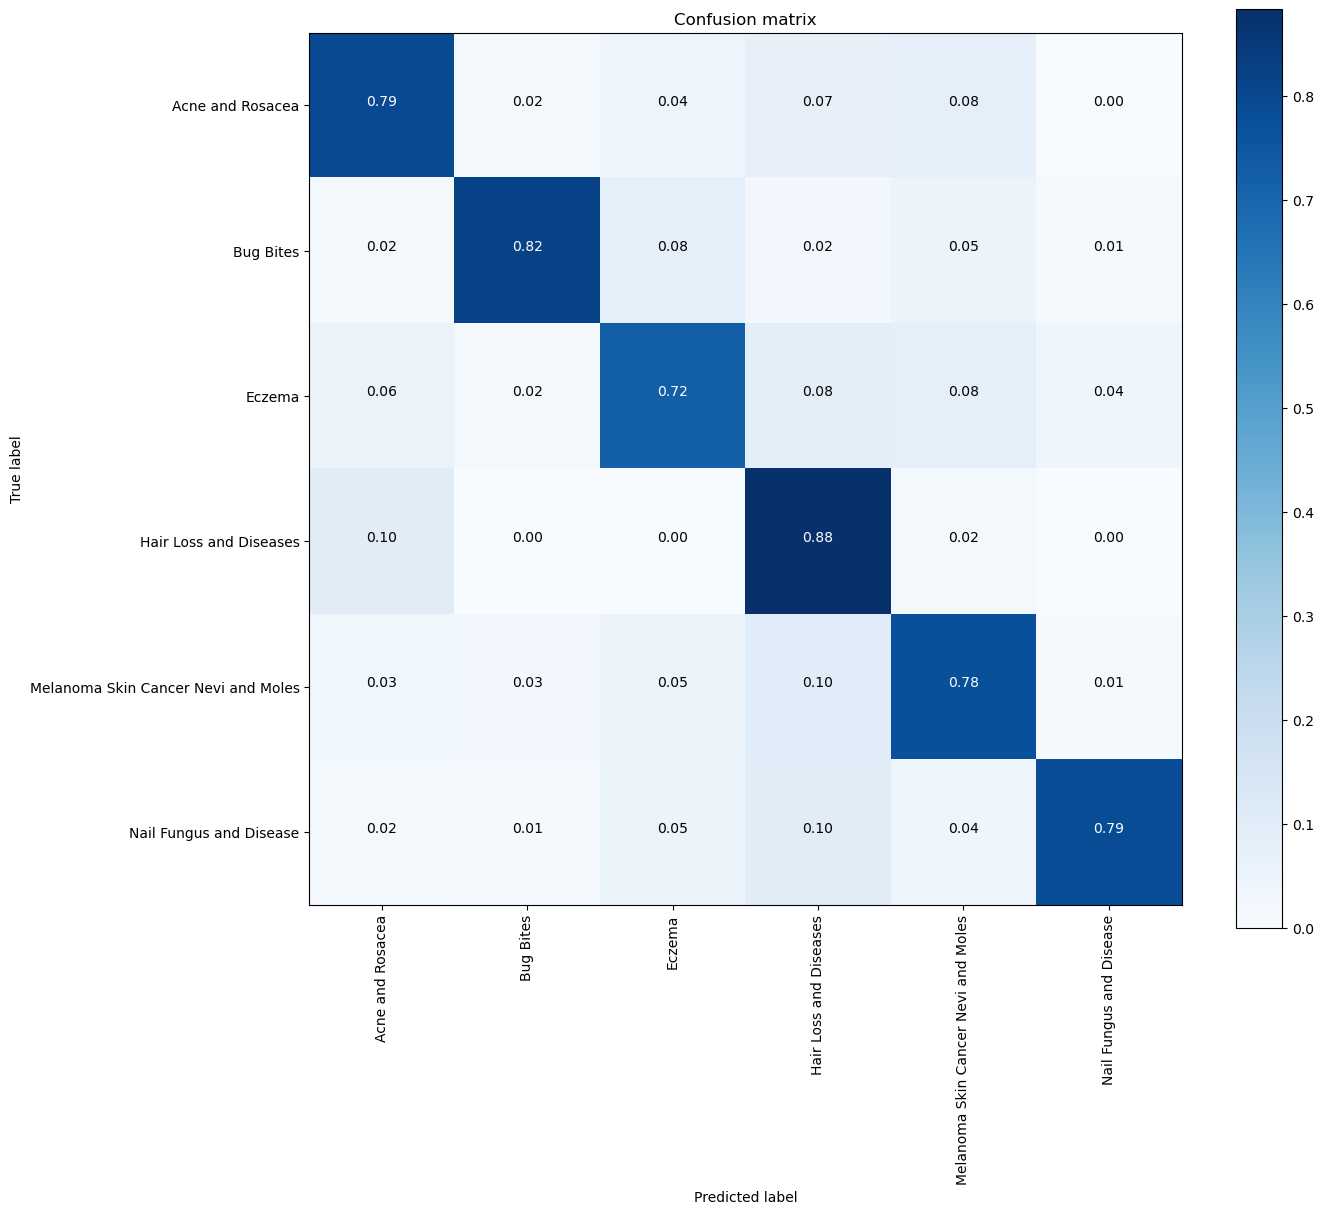

Classification Report:
{'Acne and Rosacea': {'precision': 0.8641114982578397, 'recall': 0.7948717948717948, 'f1-score': 0.8280467445742905, 'support': 312.0}, 'Bug Bites': {'precision': 0.9492063492063492, 'recall': 0.8191780821917808, 'f1-score': 0.8794117647058823, 'support': 365.0}, 'Eczema': {'precision': 0.7824561403508772, 'recall': 0.7216828478964401, 'f1-score': 0.7508417508417509, 'support': 309.0}, 'Hair Loss and Diseases': {'precision': 0.36054421768707484, 'recall': 0.8833333333333333, 'f1-score': 0.5120772946859904, 'support': 60.0}, 'Melanoma Skin Cancer Nevi and Moles': {'precision': 0.5421686746987951, 'recall': 0.7758620689655172, 'f1-score': 0.6382978723404256, 'support': 116.0}, 'Nail Fungus and Disease': {'precision': 0.9192825112107623, 'recall': 0.7854406130268199, 'f1-score': 0.8471074380165289, 'support': 261.0}, 'accuracy': 0.7856640899508082, 'macro avg': {'precision': 0.7362948985686164, 'recall': 0.7967281233809477, 'f1-score': 0.7426304775274781, 'support':

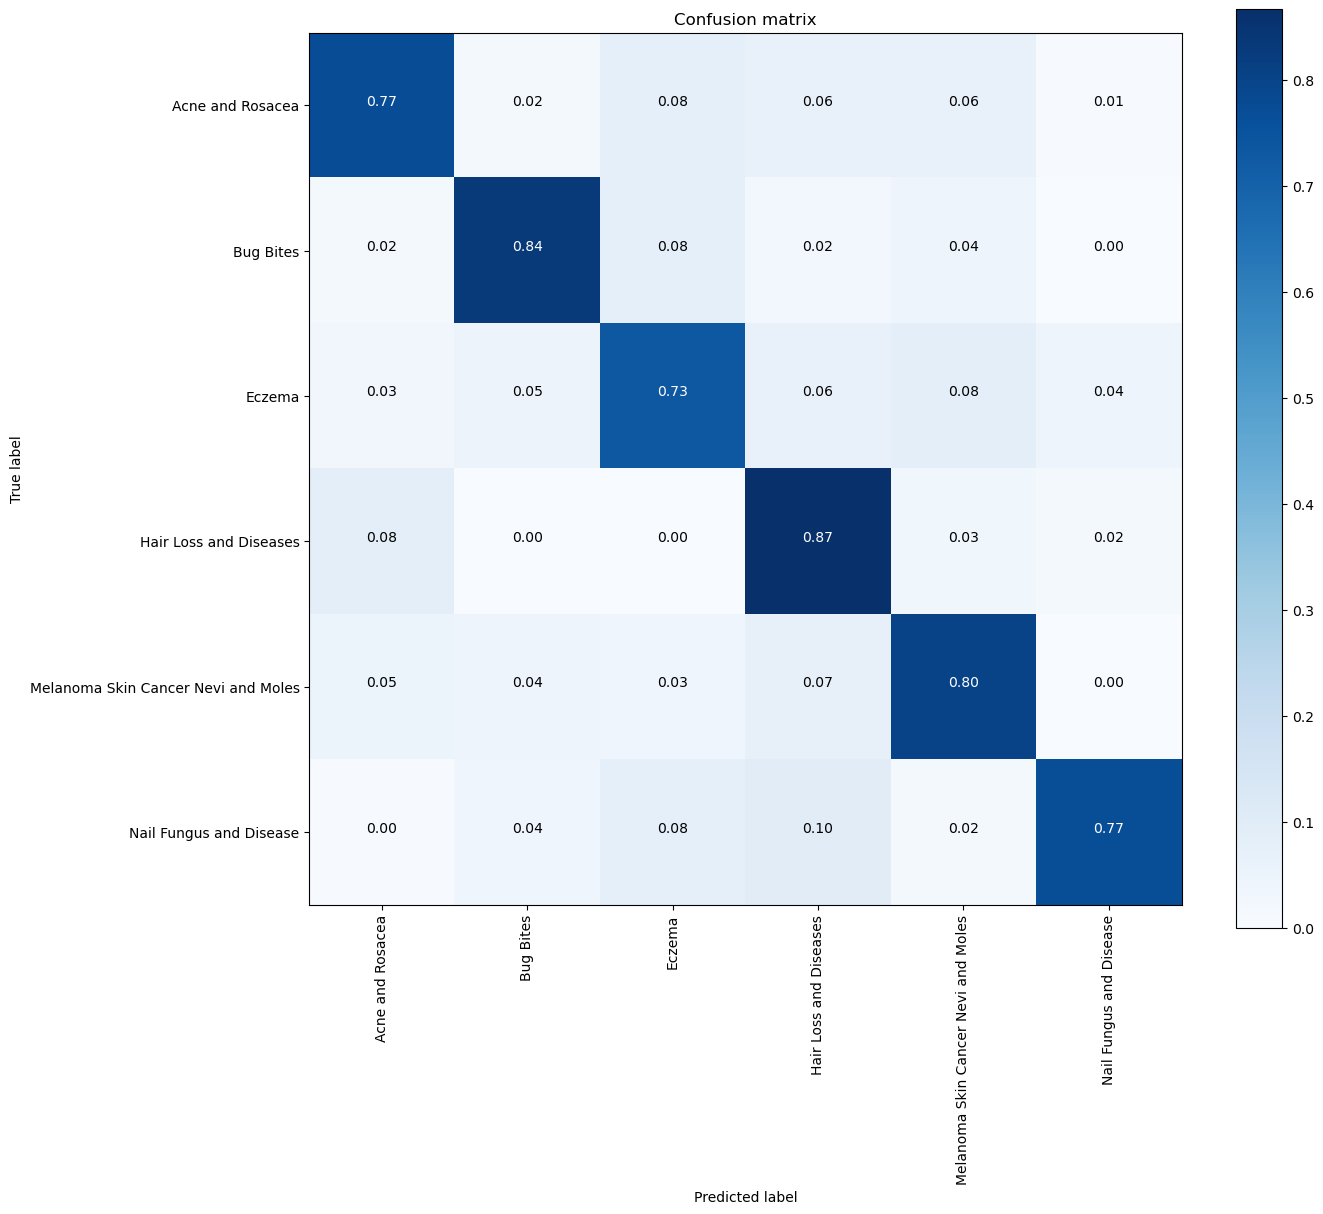

Classification Report:
{'Acne and Rosacea': {'precision': 0.8955223880597015, 'recall': 0.7692307692307693, 'f1-score': 0.8275862068965517, 'support': 312.0}, 'Bug Bites': {'precision': 0.8970588235294118, 'recall': 0.8356164383561644, 'f1-score': 0.8652482269503546, 'support': 365.0}, 'Eczema': {'precision': 0.740983606557377, 'recall': 0.7313915857605178, 'f1-score': 0.7361563517915309, 'support': 309.0}, 'Hair Loss and Diseases': {'precision': 0.39097744360902253, 'recall': 0.8666666666666667, 'f1-score': 0.538860103626943, 'support': 60.0}, 'Melanoma Skin Cancer Nevi and Moles': {'precision': 0.577639751552795, 'recall': 0.8017241379310345, 'f1-score': 0.6714801444043321, 'support': 116.0}, 'Nail Fungus and Disease': {'precision': 0.9259259259259259, 'recall': 0.7662835249042146, 'f1-score': 0.8385744234800838, 'support': 261.0}, 'accuracy': 0.7842586085734364, 'macro avg': {'precision': 0.7380179898723723, 'recall': 0.7951521871415612, 'f1-score': 0.7463175761916329, 'support': 14

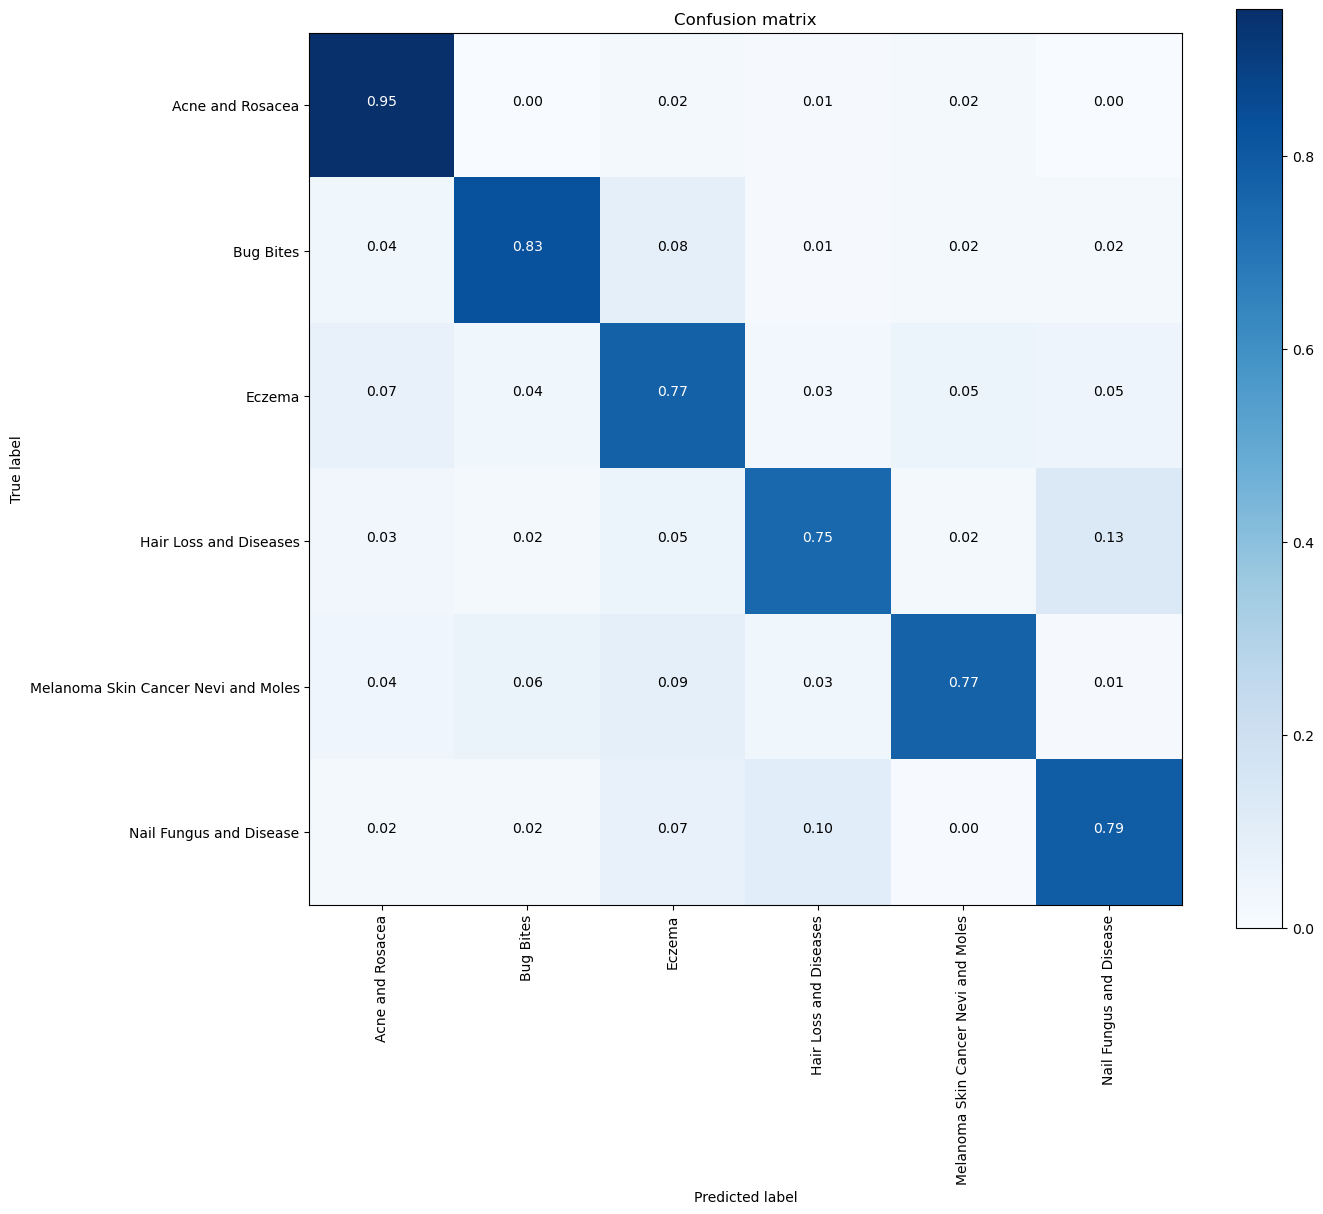

Classification Report:
{'Acne and Rosacea': {'precision': 0.8633720930232558, 'recall': 0.9519230769230769, 'f1-score': 0.9054878048780488, 'support': 312.0}, 'Bug Bites': {'precision': 0.9296636085626911, 'recall': 0.8328767123287671, 'f1-score': 0.8786127167630058, 'support': 365.0}, 'Eczema': {'precision': 0.7777777777777778, 'recall': 0.7702265372168284, 'f1-score': 0.7739837398373983, 'support': 309.0}, 'Hair Loss and Diseases': {'precision': 0.4891304347826087, 'recall': 0.75, 'f1-score': 0.5921052631578947, 'support': 60.0}, 'Melanoma Skin Cancer Nevi and Moles': {'precision': 0.7416666666666667, 'recall': 0.7672413793103449, 'f1-score': 0.7542372881355932, 'support': 116.0}, 'Nail Fungus and Disease': {'precision': 0.8760683760683761, 'recall': 0.7854406130268199, 'f1-score': 0.8282828282828283, 'support': 261.0}, 'accuracy': 0.8278285312719607, 'macro avg': {'precision': 0.7796131594802294, 'recall': 0.8096180531343062, 'f1-score': 0.788784940175795, 'support': 1423.0}, 'weigh

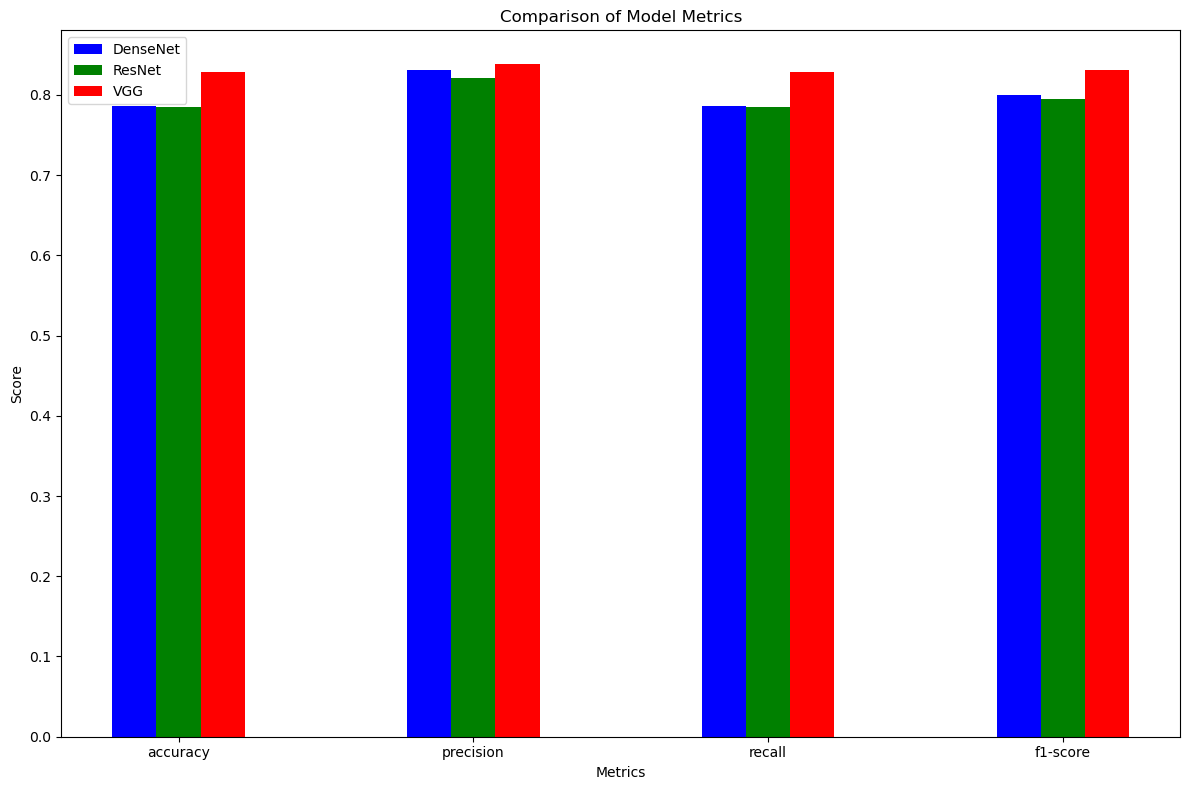

In [96]:
compare_and_plot(n_models, test_data_loader, class_names)